In [1]:
#@title <font size="5">← ឵឵<i>Upgrade FFmpeg to v4.2.2</font> { vertical-output: true }
from IPython.display import clear_output
import os, urllib.request
HOME = os.path.expanduser("~")
pathDoneCMD = f'{HOME}/doneCMD.sh'
if not os.path.exists(f"{HOME}/.ipython/ttmg.py"):
    hCode = "https://raw.githubusercontent.com/yunooooo/gcct/master/res/ttmg.py"
    urllib.request.urlretrieve(hCode, f"{HOME}/.ipython/ttmg.py")

from ttmg import (
    loadingAn,
    textAn,
)

loadingAn(name="lds")
textAn("Installing Dependencies...", ty='twg')
os.system('pip install git+git://github.com/AWConant/jikanpy.git')
os.system('add-apt-repository -y ppa:jonathonf/ffmpeg-4')
os.system('apt-get update')
os.system('apt install mediainfo')
os.system('apt-get install ffmpeg')
clear_output()
print('Installation finished.')

Installation finished.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%capture
!pip install mediapipe

In [4]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


In [5]:


# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip



In [6]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

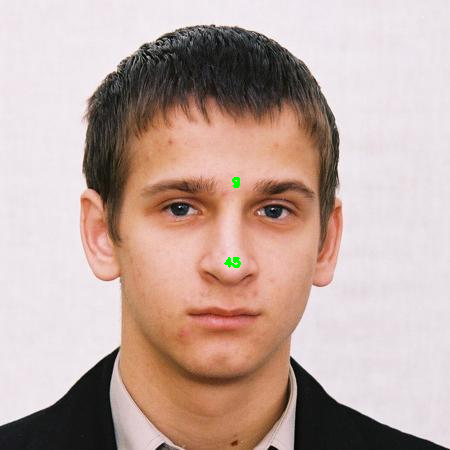

In [7]:
# choosing random image
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      index = 0
      for face in results.multi_face_landmarks:
          nose_x = face.landmark[45].x
          nose_y = face.landmark[45].y

          p2_x = face.landmark[9].x
          p2_y = face.landmark[9].y

          dist = np.sqrt((p2_x - nose_x)**2 + (p2_y - nose_y)**2)
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              if index == 9   or index == 45:
                cv2.putText(image, str(index), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              index +=1
      cv2_imshow(image)


In [8]:
def read_image(imagefile):
  faceModule = mediapipe.solutions.face_mesh
  X = []
  Y = []
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread('/content/AFLW2000/'+imagefile+'.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            nose_x = face.landmark[45].x
            nose_y = face.landmark[45].y
            shape = image.shape 
            nose_relative_x = int(nose_x * shape[1])
            nose_relative_y = int(nose_y * shape[0])

            p2_x = face.landmark[9].x
            p2_y = face.landmark[9].y

            p2_relative_x = int(p2_x * shape[1])
            p2_relative_y = int(p2_y * shape[0])

            dist = np.sqrt((p2_relative_x - nose_relative_x)**2 + (p2_relative_y - nose_relative_y)**2)
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                X.append((relative_x-nose_relative_x)/dist)
                Y.append((relative_y-nose_relative_y)/dist)
                # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                #cv2.circle(image, (relative_x-nose_relative_x, relative_y-nose_relative_y), radius=1, color=(0, 255, 0), thickness=2)
      #cv2_imshow(image)
      # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
      mat_file = sio.loadmat('/content/AFLW2000/'+imagefile+'.mat')
      # extracting the labels 3 angels
      pose_para = mat_file["Pose_Para"][0][:3]
      pitch = pose_para[0]
      yaw = pose_para[1]
      roll = pose_para[2]
      if len(X) == 0:
        return None
      return X, Y, pitch, yaw, roll

In [9]:
# landmarks = face.location_data.relative_keypoints
 
# right_eye = (int(landmarks[0].x * img.shape[1]), int(landmarks[0].y * img.shape[0]))
# left_eye = (int(landmarks[1].x * img.shape[1]), int(landmarks[1].y * img.shape[0]))
# nose = (int(landmarks[2].x * img.shape[1]), int(landmarks[2].y * img.shape[0]))
# mouth = (int(landmarks[3].x * img.shape[1]), int(landmarks[3].y * img.shape[0]))
# right_ear = (int(landmarks[4].x * img.shape[1]), int(landmarks[4].y * img.shape[0]))
# left_ear = (int(landmarks[5].x * img.shape[1]), int(landmarks[5].y * img.shape[0]))
 

In [10]:
X =[]
Y= []
Pitch = []
Yaw = []
Roll = [] 
for filename in os.listdir('/content/AFLW2000/'):
  if filename.endswith("jpg"): 
    data = read_image(filename[:-4])
    if data == None:
      pass
    else:
      X.append(data[0])
      Y.append(data[1])
      Pitch.append(data[2])
      Yaw.append(data[3])
      Roll.append(data[4])

In [11]:
columns_x = list(range(0,468)) 
columns_x = [str(column_x) + '_x' for column_x in columns_x]

columns_y = list(range(0,468)) 
columns_y = [str(column_y) + '_y' for column_y in columns_y]

In [12]:
X = pd.DataFrame(X)
X.columns = columns_x
X.shape

(1853, 468)

In [13]:
Y = pd.DataFrame(Y)
Y.columns = columns_y
Y.shape

(1853, 468)

In [14]:
pitch_yaw_roll = pd.DataFrame([Pitch, Yaw, Roll]).T
pitch_yaw_roll.shape

(1853, 3)

In [15]:
pitch_yaw_roll.columns = ['pitch', 'yaw', 'roll']
pitch_yaw_roll.head()

,pitch,yaw,roll
0,0.075391,0.066288,-0.076080
1,-0.514121,0.752342,-0.341487
2,-0.347319,-0.027759,-0.091287
3,-0.029032,0.567679,0.240908
4,0.442086,0.223025,0.786156


In [16]:
df = pd.concat((X, Y, pitch_yaw_roll), axis=1)

In [17]:
df.head(20)

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,461_y,462_y,463_y,464_y,465_y,466_y,467_y,pitch,yaw,roll
0,0.140461,0.102154,0.127692,0.012769,0.102154,0.102154,0.102154,-0.702306,0.102154,0.089384,...,0.166000,0.191538,-0.549075,-0.523537,-0.510768,-0.663998,-0.702306,0.075391,0.066288,-0.076080
1,0.266683,0.064004,0.256015,0.074671,0.032002,0.053337,0.202679,0.053337,0.213346,0.192012,...,0.117340,0.128008,-0.661373,-0.608037,-0.565368,-0.736044,-0.832050,-0.514121,0.752342,-0.341487
2,0.132646,0.102036,0.112239,-0.010204,0.091832,0.081628,0.040814,-0.704045,0.020407,0.010204,...,0.102036,0.102036,-0.704045,-0.663231,-0.622417,-0.867302,-0.908116,-0.347319,-0.027759,-0.091287
3,0.124035,0.046513,0.186052,0.155043,0.062017,0.124035,0.372104,0.062017,0.480635,0.496139,...,0.217061,0.232565,-0.418617,-0.403113,-0.387609,-0.310087,-0.341096,-0.029032,0.567679,0.240908
4,-0.236352,-0.013131,-0.026261,0.236352,0.065653,0.196960,0.538356,0.091915,0.761577,0.866622,...,0.302005,0.354527,0.131306,0.091915,0.052523,0.498964,0.512095,0.442086,0.223025,0.786156
5,0.365184,0.126410,0.280911,-0.028091,0.056182,0.028091,-0.014046,-0.435412,-0.112364,-0.182592,...,0.042137,0.042137,-0.814642,-0.744414,-0.702278,-1.137690,-1.221963,-0.364073,0.213283,-0.491296
6,0.096418,0.096418,0.096418,0.000000,0.096418,0.096418,0.085705,-0.674927,0.085705,0.085705,...,0.128557,0.139271,-0.685640,-0.642787,-0.610648,-0.792771,-0.824911,-0.198142,0.014930,-0.011545
7,-0.035872,0.059787,0.047830,0.119574,0.095659,0.143489,0.298935,-0.322850,0.394595,0.442424,...,0.215233,0.227191,-0.442424,-0.430467,-0.418509,-0.370680,-0.382637,-0.013635,0.115016,0.314211
8,0.245404,0.109068,0.231770,0.068168,0.081801,0.109068,0.204503,-0.313572,0.218137,0.190870,...,0.149969,0.177236,-0.668044,-0.613510,-0.572609,-0.777112,-0.831646,-0.077474,0.369024,-0.084786
9,-0.108238,0.084185,-0.024053,-0.024053,0.108238,0.096211,0.048106,-0.853874,0.048106,0.060132,...,0.132290,0.132290,-0.661451,-0.625372,-0.589293,-0.769689,-0.817795,-0.390566,-0.244511,0.122831


In [18]:
df.shape

(1853, 939)

In [19]:
df.to_csv("data.csv", index=None)

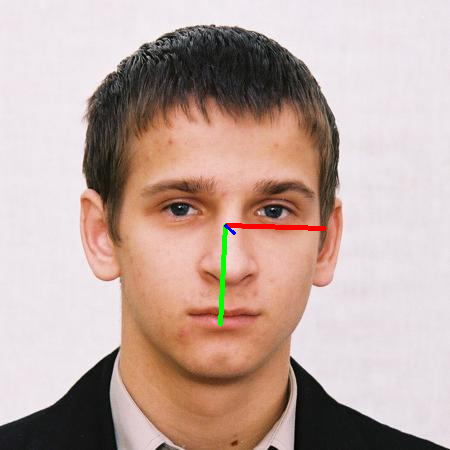

In [20]:


image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))



# Train test Split

In [21]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.3)

In [22]:
X_train = df_train.drop(columns = ['yaw', 'pitch', 'roll'])
X_test = df_test.drop(columns = ['yaw', 'pitch', 'roll'])

In [23]:
y_train_yaw = df_train['yaw']
y_train_pitch = df_train['pitch']
y_train_roll = df_train['roll']

y_test_yaw= df_test['yaw']
y_test_pitch= df_test['pitch']
y_test_roll= df_test['roll']

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.999)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

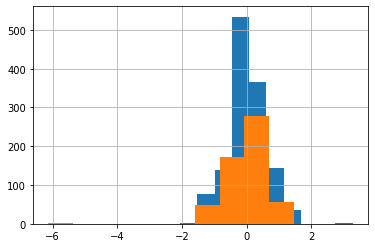

In [25]:
y_train_yaw.hist()
y_test_yaw.hist()

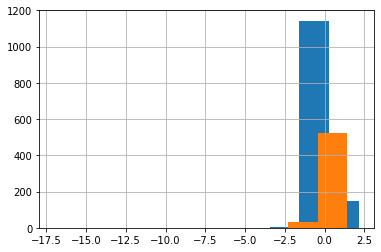

In [26]:
y_train_roll.hist()
y_test_roll.hist()

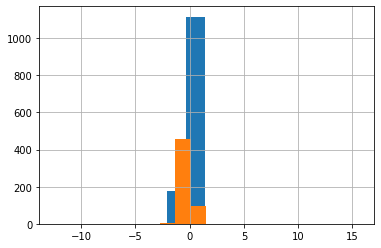

In [27]:
y_train_pitch.hist()
y_test_pitch.hist()

In [28]:
y_train_yaw.shape

(1297,)

In [29]:
X_train.shape

(1297, 14)

In [30]:
from sklearn.model_selection import GridSearchCV

## Scaling

In [31]:
# #Normalize
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model 1 -> Linear Regression "Baseline"

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [33]:
from sklearn.metrics import mean_squared_error

In [34]:
def fit_predict_model(model1, model2, model3):
  Model_yaw = model1.fit(X_train, y_train_yaw)
  Model_pitch = model2.fit(X_train, y_train_pitch)
  Model_roll = model3.fit(X_train, y_train_roll)

  pred_yaw_t = Model_yaw.predict(X_train)
  pred_pitch_t = Model_pitch.predict(X_train)
  pred_roll_t = Model_roll.predict(X_train)

  pred_yaw = Model_yaw.predict(X_test)
  pred_pitch = Model_pitch.predict(X_test)
  pred_roll = Model_roll.predict(X_test)

  r2_yaw_t = r2_score(y_train_yaw, pred_yaw_t)
  r2_pitch_t = r2_score(y_train_pitch, pred_pitch_t)
  r2_roll_t = r2_score(y_train_roll, pred_roll_t)

  #R2 score
  r2_yaw = r2_score(y_test_yaw, pred_yaw)
  r2_pitch = r2_score(y_test_pitch, pred_pitch)
  r2_roll = r2_score(y_test_roll, pred_roll)

  return [r2_yaw, r2_pitch, r2_roll, r2_yaw_t, r2_pitch_t, r2_roll_t]

In [35]:
scores = fit_predict_model(LinearRegression(), LinearRegression(), LinearRegression())

In [36]:
results = pd.DataFrame([['LinearRegression'] + scores], columns = ['Model','r2_yaw_test', 'r2_pitch_test', 'r2_roll_test', 'r2_yaw_train', 'r2_pitch_train', 'r2_roll_train'])

In [37]:
results

,Model,r2_yaw_test,r2_pitch_test,r2_roll_test,r2_yaw_train,r2_pitch_train,r2_roll_train
0,LinearRegression,0.751608,0.080789,0.260127,0.899582,0.193976,0.333065


## Model 2 -> Ridge Regression

In [38]:
from sklearn.linear_model import Ridge

In [39]:
params = { 'alpha' : [0.1, 0.2, 0.5, 1], 'max_iter' : [10000]}


l1 = Ridge()
model1 = GridSearchCV(l1, params, cv=3)
l2 = Ridge()
model2 = GridSearchCV(l2, params, cv=3)
l3 = Ridge()
model3 = GridSearchCV(l3, params, cv=3)
scores = fit_predict_model(model1, model2, model3)

In [40]:
print(model1.best_params_)
print(model2.best_params_)
print(model3.best_params_)

{'alpha': 1, 'max_iter': 10000}
{'alpha': 1, 'max_iter': 10000}
{'alpha': 1, 'max_iter': 10000}


In [41]:
results.loc[1] = ['Ridge']+scores
results

,Model,r2_yaw_test,r2_pitch_test,r2_roll_test,r2_yaw_train,r2_pitch_train,r2_roll_train
0,LinearRegression,0.751608,0.080789,0.260127,0.899582,0.193976,0.333065
1,Ridge,0.751607,0.080852,0.260054,0.899582,0.193976,0.333065


## Model 3 -> lasso

In [42]:
from sklearn.linear_model import Lasso

In [43]:
params = { 'alpha' : [0.001, 0.1, 1, 10], 'max_iter' : [1000]}

l1 = Lasso()
model1 = GridSearchCV(l1, params, cv=3)
l2 = Lasso()
model2 = GridSearchCV(l2, params, cv=3)
l3 = Lasso()
model3 = GridSearchCV(l3, params, cv=3)
scores = fit_predict_model(model1, model2, model3)
scores

[0.7514749032820799,
 0.0826658845124163,
 0.15398835285649481,
 0.8995388542924949,
 0.1939254040070595,
 0.22941626309626473]

In [44]:
print(model1.best_params_)
print(model2.best_params_)
print(model3.best_params_)

{'alpha': 0.001, 'max_iter': 1000}
{'alpha': 0.001, 'max_iter': 1000}
{'alpha': 0.1, 'max_iter': 1000}


In [45]:
results.loc[2] = ['Lasso']+scores
results

,Model,r2_yaw_test,r2_pitch_test,r2_roll_test,r2_yaw_train,r2_pitch_train,r2_roll_train
0,LinearRegression,0.751608,0.080789,0.260127,0.899582,0.193976,0.333065
1,Ridge,0.751607,0.080852,0.260054,0.899582,0.193976,0.333065
2,Lasso,0.751475,0.082666,0.153988,0.899539,0.193925,0.229416


## model 3 -> support vector machine

In [46]:
from sklearn.svm import SVR

In [47]:
params = {'kernel': ['rbf'], 
          'gamma': [1e-4, 1e-3, 0.01, 0.1],
          'C': [1, 10, 100, 1000]
          }


svr1 = SVR()
model1 = GridSearchCV(svr1, params, cv=3)

svr2 = SVR()
model2 = GridSearchCV(svr2, params, cv=3)

svr3 = SVR()
model3 = GridSearchCV(svr3, params, cv=3)

scores = fit_predict_model(model1, model2, model3)
print(scores)

[0.7554513546306953, 0.15604086053920452, 0.2477988946386549, 0.9241194688424756, 0.2261542010641796, 0.36504300320256144]


In [48]:
print(model1.best_params_)
print(model2.best_params_)
print(model3.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [49]:
results.loc[3] = ['SVR_rbf']+scores
results

,Model,r2_yaw_test,r2_pitch_test,r2_roll_test,r2_yaw_train,r2_pitch_train,r2_roll_train
0,LinearRegression,0.751608,0.080789,0.260127,0.899582,0.193976,0.333065
1,Ridge,0.751607,0.080852,0.260054,0.899582,0.193976,0.333065
2,Lasso,0.751475,0.082666,0.153988,0.899539,0.193925,0.229416
3,SVR_rbf,0.755451,0.156041,0.247799,0.924119,0.226154,0.365043


## Model 4-> XGBOOST

In [50]:
from sklearn.ensemble import GradientBoostingRegressor 

In [51]:
params = {
    "n_estimators": [30],
    "max_depth": [2,3,4,5],
    "min_samples_split": [2,3,4],
    "learning_rate": [0.001, 0.01, 0.1, 0.2]
}

GBreg1 = GradientBoostingRegressor()
model1 = GridSearchCV(GBreg1, params, cv=3)

GBreg2 = GradientBoostingRegressor()
model2 = GridSearchCV(GBreg2, params, cv=3)

GBreg3 = GradientBoostingRegressor()
model3 = GridSearchCV(GBreg3, params, cv=3)

scores = fit_predict_model(model1, model2, model3)
print(scores)

[0.7493766167767366, 0.05484501534972119, 0.14133697009385193, 0.9828330000045324, 0.9106609804146166, 0.42150408286908647]


In [52]:
print(model1.best_params_)
print(model2.best_params_)
print(model3.best_params_)

{'learning_rate': 0.2, 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 30}
{'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 30}
{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 30}


In [53]:
results.loc[4] = ['GradientBoostingRegressor']+scores
results

,Model,r2_yaw_test,r2_pitch_test,r2_roll_test,r2_yaw_train,r2_pitch_train,r2_roll_train
0,LinearRegression,0.751608,0.080789,0.260127,0.899582,0.193976,0.333065
1,Ridge,0.751607,0.080852,0.260054,0.899582,0.193976,0.333065
2,Lasso,0.751475,0.082666,0.153988,0.899539,0.193925,0.229416
3,SVR_rbf,0.755451,0.156041,0.247799,0.924119,0.226154,0.365043
4,GradientBoostingRegressor,0.749377,0.054845,0.141337,0.982833,0.910661,0.421504


In [54]:
results

,Model,r2_yaw_test,r2_pitch_test,r2_roll_test,r2_yaw_train,r2_pitch_train,r2_roll_train
0,LinearRegression,0.751608,0.080789,0.260127,0.899582,0.193976,0.333065
1,Ridge,0.751607,0.080852,0.260054,0.899582,0.193976,0.333065
2,Lasso,0.751475,0.082666,0.153988,0.899539,0.193925,0.229416
3,SVR_rbf,0.755451,0.156041,0.247799,0.924119,0.226154,0.365043
4,GradientBoostingRegressor,0.749377,0.054845,0.141337,0.982833,0.910661,0.421504


## XGBRegressor

In [55]:
from xgboost import XGBRegressor

In [56]:
xg1 = XGBRegressor(learning_rate=0.5, max_depth=2, n_estimators=60)
xg1.fit(np.array(X_train), y_train_roll)
pred_train = xg1.predict(np.array(X_train))
pred_test = xg1.predict(np.array(X_test))


r2_train = r2_score(y_train_roll, pred_train)
r2_test = r2_score(y_test_roll, pred_test)

print(r2_train, r2_test)

[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9749736679994333 0.2156462629078575


In [57]:
xg1 = XGBRegressor(learning_rate=0.9, max_depth=1, n_estimators=60)
xg1.fit(np.array(X_train), y_train_pitch)
pred_train = xg1.predict(np.array(X_train))
pred_test = xg1.predict(np.array(X_test))


r2_train = r2_score(y_train_pitch, pred_train)
r2_test = r2_score(y_test_pitch, pred_test)
print(mean_squared_error(y_train_pitch, xg1.predict(X_train)))
print(mean_squared_error(y_test_pitch, xg1.predict(X_test)))
print(r2_train, r2_test)

[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.030542630339633014
0.613506040907398
0.8891214258348311 -0.6998743946244694


In [58]:
params = {'learning_rate':[0.6], 'max_depth':[1,2,3], 'n_estimators':[10]}

xg1 = XGBRegressor()
model1 = GridSearchCV(xg1, params)

xg2 = XGBRegressor()
model2 = GridSearchCV(xg2, params)

xg3 = XGBRegressor()
model3 = GridSearchCV(xg3, params)

scores = fit_predict_model(model1, model2, model3)
print(scores)

[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [59]:
print(model1.best_params_)
print(model2.best_params_)
print(model3.best_params_)

{'learning_rate': 0.6, 'max_depth': 3, 'n_estimators': 10}
{'learning_rate': 0.6, 'max_depth': 1, 'n_estimators': 10}
{'learning_rate': 0.6, 'max_depth': 1, 'n_estimators': 10}


In [60]:
results.loc[5] = ['xgboost']+scores
results

,Model,r2_yaw_test,r2_pitch_test,r2_roll_test,r2_yaw_train,r2_pitch_train,r2_roll_train
0,LinearRegression,0.751608,0.080789,0.260127,0.899582,0.193976,0.333065
1,Ridge,0.751607,0.080852,0.260054,0.899582,0.193976,0.333065
2,Lasso,0.751475,0.082666,0.153988,0.899539,0.193925,0.229416
3,SVR_rbf,0.755451,0.156041,0.247799,0.924119,0.226154,0.365043
4,GradientBoostingRegressor,0.749377,0.054845,0.141337,0.982833,0.910661,0.421504
5,xgboost,0.742460,-0.088359,0.179937,0.954366,0.476190,0.526241


## Final Models

In [61]:
from sklearn.ensemble import VotingRegressor

In [62]:
# pitch
svr_pitch = SVR(C= 100, gamma= 0.001, kernel= 'rbf')
xg_pitch = XGBRegressor(learning_rate=0.9, max_depth=1, n_estimators=60)
m_pitch = VotingRegressor([('svr', svr_pitch), ('xg_pitch', xg_pitch)])
m_pitch.fit(X_train, y_train_pitch)
train_pitch_pred = m_pitch.predict(X_train)
test_pitch_pred = m_pitch.predict(X_test)

r2_train_pitch = r2_score(y_train_pitch, train_pitch_pred)
r2_test_pitch = r2_score(y_test_pitch, test_pitch_pred)

[15:20:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [63]:
print(r2_train_pitch, r2_test_pitch)

0.7063936313359551 -0.034819411082403384


In [64]:
# roll
xg_roll = XGBRegressor(learning_rate=0.5, max_depth=2, n_estimators=60)
svr_roll= SVR(C= 10, gamma= 0.01, kernel= 'rbf')
m_roll = VotingRegressor([('svr', svr_roll), ('xg_roll', xg_roll)])
m_roll.fit(X_train, y_train_roll)
train_roll_pred = m_roll.predict(X_train)
test_roll_pred = m_roll.predict(X_test)


r2_train_roll = r2_score(y_train_roll, train_roll_pred)
r2_test_roll = r2_score(y_test_roll, test_roll_pred)

[15:20:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
print(r2_train_roll, r2_test_roll)

0.8289468517567564 0.24833240053954064


In [66]:
# yaw
m_yaw = XGBRegressor(learning_rate=0.6, max_depth=3, n_estimators=10)
m_yaw.fit(X_train, y_train_yaw)
train_yaw_pred = m_yaw.predict(X_train)
test_yaw_pred = m_yaw.predict(X_test)

r2_train_yaw = r2_score(y_train_yaw, train_yaw_pred)
r2_test_yaw = r2_score(y_test_yaw, test_yaw_pred)

[15:20:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [67]:
print(r2_train_yaw, r2_test_yaw)

0.9543663466525963 0.7424598341343125


## Test and visualize

In [68]:
random_file = 'image00002'

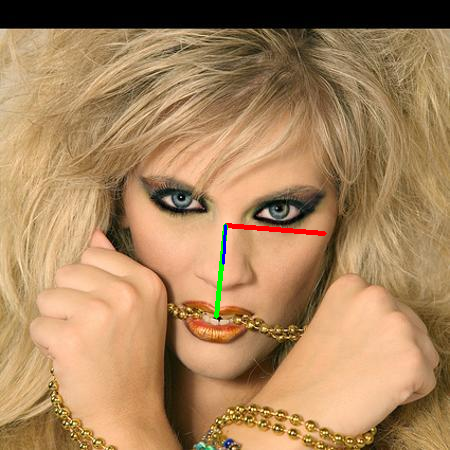

In [69]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))


In [70]:
def predict_yaw_pitch_roll(imagefile, isfilename=True):
  faceModule = mediapipe.solutions.face_mesh
  X = []
  Y = []
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      if isfilename:
        image = cv2.imread(imagefile)
      else:
        image = imagefile
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            nose_x = face.landmark[45].x
            nose_y = face.landmark[45].y
            shape = image.shape 
            nose_relative_x = int(nose_x * shape[1])
            nose_relative_y = int(nose_y * shape[0])

            p2_x = face.landmark[9].x
            p2_y = face.landmark[9].y

            p2_relative_x = int(p2_x * shape[1])
            p2_relative_y = int(p2_y * shape[0])

            dist = np.sqrt((p2_relative_x - nose_relative_x)**2 + (p2_relative_y - nose_relative_y)**2)
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                
                # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                shape = image.shape 
                relative_x = int(x * shape[1])
                relative_y = int(y * shape[0])
                X.append((relative_x-nose_relative_x)/dist)
                Y.append((relative_y-nose_relative_y)/dist)

      if len(X) == 0:
        return None


      columns_x = list(range(0,468)) 
      columns_x = [str(column_x) + '_x' for column_x in columns_x]

      columns_y = list(range(0,468)) 
      columns_y = [str(column_y) + '_y' for column_y in columns_y]

      X = pd.DataFrame(X).T
      X.columns = columns_x

      Y = pd.DataFrame(Y).T
      Y.columns = columns_y

      features = pd.concat((X, Y), axis=1)
      #(1, 936)

      features_pca = pca.transform(features)

      features_scaled = scaler.transform(features_pca)


      roll = m_roll.predict(features_scaled)
      pitch = m_pitch.predict(features_scaled)
      yaw = m_yaw.predict(features_scaled)
      
      return roll[0], pitch[0], yaw[0] , nose_relative_x, nose_relative_y

In [71]:
roll_pred, pitch_pred, yaw_pred, nose_x, nose_y = predict_yaw_pitch_roll('/content/AFLW2000/'+random_file+'.jpg')

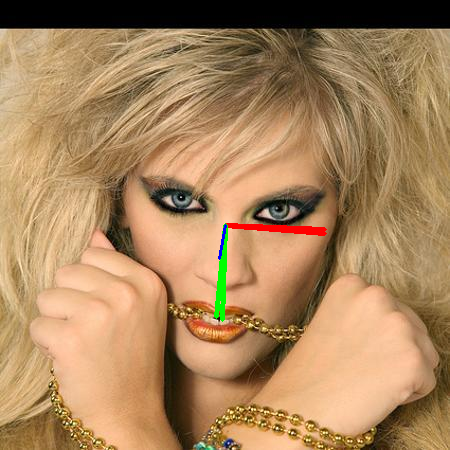

In [72]:
cv2_imshow(draw_axis(image,pitch_pred,yaw_pred,roll_pred))

In [73]:
def put_roll_yaw_pitch(img):
    # Now we are reading image using openCV
    # img= cv2.imread(image)
    imageRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    roll, pitch, yaw = predict_yaw_pitch_roll(imageRGB)

    frame = draw_axis(imageRGB,pitch,yaw,roll)

    return frame

## Test On Video

In [93]:
videoname = 'theoffice1.mp4'

In [94]:
import cv2
vidcap = cv2.VideoCapture(videoname)
success,image = vidcap.read()
count = 0
img_array =[]
while success:
  #cv2.imwrite("videoframes/frame%d.jpg" % count, image)     # save frame as JPEG file    
  img_array.append(image)  
  success,image = vidcap.read()
  count += 1


In [95]:
edited_img_array = []
pitch_prev = []
yaw_prev = []
roll_prev = []
for i in range(len(img_array)):
  #filename = 'videoframes/frame'+str(i) + '.jpg'
  #print(filename)
  #cv2_imshow(cv2.imread(filename))
  output_labels = predict_yaw_pitch_roll(img_array[i], False)
  if output_labels:
    roll_pred, pitch_pred, yaw_pred, nose_x, nose_y = output_labels
    #img = cv2.imread(filename)
    img = img_array[i]
    pitch_prev.append(pitch_pred)
    yaw_prev.append(yaw_pred)
    roll_prev.append(roll_pred)
    if i > 3:
      pitch_pred_edit = np.mean(pitch_prev[-3:])
      yaw_pred_edit = np.mean(yaw_prev[-3:])
      roll_pred_edit = np.mean(roll_prev[-3:])
      new_frame = draw_axis(img,pitch_pred_edit,yaw_pred_edit,roll_pred_edit, nose_x, nose_y)
    else:
      new_frame = draw_axis(img,pitch_pred,yaw_pred,roll_pred, nose_x, nose_y)
    #cv2_imshow(new_frame)
  else:
    #new_frame = cv2.imread(filename)
    new_frame = img_array[i]
    #cv2_imshow(new_frame)

  edited_img_array.append(new_frame)


In [96]:
s1,s2,s3 = edited_img_array[0].shape
fourcc = cv2.VideoWriter_fourcc(*"XVID")
out = cv2.VideoWriter('project_theoffice1_5.mp4', fourcc, 25, (s2, s1), True)
 
for i in range(len(edited_img_array)):
    out.write(edited_img_array[i])
out.release()